In [2]:
import sys
sys.path.append("../")

In [3]:
from utils.text_splitter import TextSplitter
from utils.chroma_store import ChromaStore
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pygit2'

In [ ]:
### Parameters
USE_FULL_DATASET = False
DEFAULT_EMBED_INSTRUCTION = "Represent the document for retrieval: "
DEFAULT_QUERY_INSTRUCTION = (
    "Represent the question for retrieving supporting documents: "
)

chroma_client = ChromaStore(chroma_server_hostname="localhost", chroma_server_port=8000)

EMBED_MODEL = "hkunlp/instructor-base"
LLM_MODEL = "google/flan-t5-base"
N_RESULTS = 4

In [ ]:
nhs_depression_cleaned_content="""Overview - Depression in adults Depression is more than simply feeling unhappy or fed up for a few days. Most people go through periods of feeling down, but when you're depressed you feel persistently sad for weeks or months, rather than just a few days. Some people think depression is trivial and not a genuine health condition. They're wrong – it is a real illness with real symptoms. Depression is not a sign of weakness or something you can "snap out of" by "pulling yourself together". The good news is that with the right treatment and support, most people with depression can make a full recovery. These pages are about depression in adults. Read about depression in children and young people .

How to tell if you have depression Depression affects people in different ways and can cause a wide variety of symptoms. They range from lasting feelings of unhappiness and hopelessness, to losing interest in the things you used to enjoy and feeling very tearful. Many people with depression also have symptoms of anxiety . There can be physical symptoms too, such as feeling constantly tired, sleeping badly, having no appetite or sex drive, and various aches and pains. The symptoms of depression range from mild to severe. At its mildest, you may simply feel persistently low in spirit, while severe depression can make you feel suicidal, that life is no longer worth living. Most people experience feelings of stress, anxiety or low mood during difficult times. A low mood may improve after a short period of time, rather than being a sign of depression.

When to see a doctor It's important to seek help from a GP if you think you may be depressed. Many people wait a long time before seeking help for depression, but it's best not to delay. The sooner you see a doctor, the sooner you can be on the way to recovery.

What causes depression? Sometimes there's a trigger for depression. Life-changing events, such as bereavement, losing your job or giving birth, can bring it on. People with a family history of depression are more likely to experience it themselves. But you can also become depressed for no obvious reason.

Treating depression Treatment for depression can involve a combination of lifestyle changes, talking therapies and medicine. Your recommended treatment will be based on how severe your depression is. If you have mild depression, your doctor may suggest waiting to see whether it improves on its own, while monitoring your progress. This is known as "watchful waiting". They may also suggest lifestyle measures such as exercise and guided self-help. Talking therapies, such as cognitive behavioural therapy (CBT) , may also be used for mild depression. For moderate to severe depression, a combination of talking therapy and antidepressants is often recommended. If you have severe depression, you may be referred to a specialist mental health team for intensive specialist talking treatments and prescribed medicine.

Living with depression Many people with depression benefit by making lifestyle changes, such as getting more exercise , cutting down on alcohol , giving up smoking and eating healthily . Reading a self-help book or joining a support group are also worthwhile. They can help you gain a better understanding about what causes you to feel depressed. Sharing your experiences with others in a similar situation can also be very supportive.

Information: Social care and support guide If you:
need help with day-to-day living because of illness or
disability care for someone regularly because they're ill or disabled, or because of their age – including family members
Our social care and support guide explains your options and where you can get support.

Symptoms - Depression in adults The symptoms of depression can be complex and vary widely between people. If you're depressed, you may feel sad, hopeless and lose interest in things you used to enjoy. The symptoms persist for weeks or months and are bad enough to interfere with your work, social life and family life. There are many other symptoms of depression and you're unlikely to have all of those listed on this page.

Psychological symptoms The psychological symptoms of depression include: continuous low mood or sadness feeling hopeless and helpless having low self-esteem feeling tearful feeling guilt-ridden feeling irritable and intolerant of others having no motivation or interest in things finding it difficult to make decisions not getting any enjoyment out of life feeling anxious or worried having suicidal thoughts or thoughts of harming yourself

Physical symptoms The physical symptoms of depression include: moving or speaking more slowly than usual changes in appetite or weight (usually decreased, but sometimes increased) constipation unexplained aches and pains lack of energy low sex drive ( loss of libido ) disturbed sleep – for example, finding it difficult to fall asleep at night or waking up very early in the morning

Social symptoms The social symptoms of depression include: avoiding contact with friends and taking part in fewer social activities neglecting your hobbies and interests having difficulties in your home, work or family life

Severities of depression Depression can often come on gradually, so it can be difficult to notice something is wrong. Many people try to cope with their symptoms without realising they're unwell. It can sometimes take a friend or family member to suggest something is wrong. Doctors describe depression in adults as either less severe (mild) or more severe (moderate or severe), based on: the symptoms, including how often you get symptoms and how bad they are how long depression lasts the impact on your daily life A few people with severe depression may have symptoms of psychosis . You'll usually be asked to answer a set of questions to help doctors assess how severe your condition is.

Grief and depression It can be difficult to distinguish between grief and depression. They share many of the same characteristics, but there are important differences between them. Grief is an entirely natural response to a loss, while depression is an illness. People who are grieving may have symptoms of depression, but they usually improve with time. For some people, bereavement can lead to depression. If you're grieving it's normal to have feelings of sadness. Some other symptoms of depression are rare with grief and bereavement, such as having suicidal thoughts, symptoms of psychosis and feeling hopeless or guilt-ridden.

Other types of depression There are different types of depression, and some conditions where depression may be one of the symptoms. These include: postnatal depression – sometimes new mothers, fathers or partners develop depression after they have a baby; this is known as postnatal depression and it's treated in a similar way to other types of depression, with talking therapies and antidepressant medicines bipolar disorder – also known as "manic depression", in bipolar disorder there are spells of both depression and excessively high mood (mania); the depression symptoms are similar to depression, but the bouts of mania can include harmful behaviour, such as gambling, going on spending sprees and having unsafe sex seasonal affective disorder (SAD) – also known as "winter depression", SAD is a type of depression with a seasonal pattern usually related to winter premenstrual dysphoric disorder (PMDD) – a severe type of premenstrual syndrome (PMS) where you have symptoms including feelings of depression and anxiety in the weeks before your period

When to seek help See a GP if you experience symptoms of depression for most of the day, every day, for more than 2 weeks. A low mood may improve after a short time.
"""

mind_depression_cleaned_content="""Depression
Learn about depression, its symptoms and possible causes, and how you can access treatment and support. Find tips on caring for yourself, and guidance for friends and family.

What is depression?
Depression is a mental health problem that involves having a low mood or losing interest and enjoyment in things. It can also cause a range of other changes to how you feel or behave.

The symptoms you experience may vary. How intense they are, how long they last, and how much they affect your daily life can also vary.

If you experience milder depression, you might have low mood but still be able to carry on with your daily life. But things may feel harder and less worthwhile.

If you have more severe depression, you might find day-to-day life much more difficult. You may also experience suicidal feelings.

It starts as sadness then I feel myself shutting down, becoming less capable of coping. Eventually, I just feel numb and empty.

When does low mood become depression?
We all have times when our mood is low, and we feel sad or fed up. Often these feelings happen for a reason and pass on their own.

But it might be depression if the feelings become so bad that they interfere with our daily life. Or if they last for several weeks or months.

Are there different types of depression?
If you're diagnosed with depression, you might also be told that it is ‘less severe’ or ‘more severe’. This describes how your symptoms are affecting you, and what treatment you're likely to be offered. You may find that the severity of your depression changes over time.

Sometimes you might hear depression being called ‘major depressive disorder’. There are some other types of depression too:

Persistent depressive disorder (PDD). PDD is continuous depression that lasts for two years or more. You may also hear it called dysthymia or chronic depression.
Seasonal affective disorder (SAD). SAD is depression that occurs at a particular time of year, or during a particular season. See our page on SAD for more information.
Antenatal depression. This is depression that occurs while you are pregnant. It is sometimes called prenatal depression.
Postnatal depression (PND). This is depression that occurs in the first year after having a baby. This can include affecting dads and partners.
Premenstrual dysphoric disorder (PMDD). This is a hormone-related disorder that affects your body but also how you feel. This can involve experiencing depression. So your doctor may describe this as a mental health problem.


Common signs and symptoms of depression
These are some common signs of depression that you may experience:

How you might feel
Down, upset or tearful
Restless, agitated or irritable
Guilty, worthless and down on yourself
Empty and numb
Isolated and unable to relate to other people
Finding no pleasure in life or things you usually enjoy
Angry or frustrated over minor things
A sense of unreality
No self-confidence or self-esteem
Hopeless and despairing
Feeling tired all the time
How you might act
Avoiding social events and activities you usually enjoy
Self-harming or suicidal behaviour
Difficulty speaking, thinking clearly or making decisions
Losing interest in sex
Difficulty remembering or concentrating on things
Using more tobacco, alcohol or other drugs than usual
Difficulty sleeping, or sleeping too much
No appetite and losing weight, or eating more than usual and gaining weight
Physical aches and pains with no obvious physical cause
Moving very slowly, or being restless and agitated
It felt like I was really tired, all the time. I had no energy or emotion about anything.

Anxiety
It's very common to experience depression and anxiety together. Some symptoms of depression can also be symptoms of anxiety, for example:

Feeling restless
Finding it difficult to concentrate
Struggling to sleep

I flit between states of anxiety and depression. At times, each seems to fuel the other.

Self-harm and suicidal feelings
If you're feeling low, you might self-harm to cope with difficult feelings. Although this might make you feel better in the short term, self-harm can be very dangerous.

When you're feeling really low and hopeless, you may also find yourself thinking about suicide. This could be thinking about the idea of suicide, or considering a plan to end your life. These thoughts can feel difficult to control, and can be very frightening.

Psychotic symptoms
If you experience depression, you might also experience some psychotic symptoms. These may include delusions, such as paranoia. Or they may be hallucinations, such as hearing voices.

If you experience psychotic symptoms as part of depression, they're likely to be linked to your depressed thoughts and feelings. This may include experiencing delusions relating to feelings of guilt. For example, you might become convinced that you've committed a crime.

These kinds of experiences can feel very real at the time. This might make it hard to understand that these experiences are also symptoms of your depression. And they can be frightening or upsetting, so it's important to seek treatment and support.

You might worry that experiencing psychotic symptoms could mean you’re given a diagnosis that doesn’t feel right for you. But discussing all of your symptoms with your doctor can help you get the right support and treatment.

How might depression affect my day-to-day life?
If you have depression, you might find that it interferes with different aspects of your life. For example, it might affect your ability to work, your relationships, or managing your finances. This can add extra stress to an already difficult experience.

It may also feel hard to explain your thoughts and feelings to others. You might want to cut yourself off from other people instead. This could lead to you feeling isolated and lonely.

It feels like I'm stuck under a huge grey-black cloud. It's dark and isolating, smothering me at every opportunity.

Can depression be a symptom of other mental health problems?
Symptoms of depression can also be part of other mental health problems, such as:

Bipolar disorder
Borderline personality disorder (BPD) and other personality disorders
Schizoaffective disorder

If you experience low mood or suicidal thoughts, this might be the reason you first speak to your doctor about your mental health. And your doctor might offer you treatment for depression without realising that you also experience other symptoms.

If you think you're experiencing other symptoms, you can talk to your doctor about this to make sure you're getting the right treatment.
"""

nhs_row = ['2576149a-d0a0-48bb-a7b4-03da36697900', nhs_depression_cleaned_content, '2023-07-21 14:42:40.264910', 'https://www.nhs.uk/mental-health/conditions/depression-in-adults/overview/']
           
mind_row = ['8531c8d9-9427-4844-9a50-ac3fe2479c67', mind_depression_cleaned_content, '2023-07-21 14:42:38.491223', 'https://www.mind.org.uk/information-support/types-of-mental-health-problems/depression/about-depression/']

In [ ]:
if USE_FULL_DATASET:
    nhs_data = pd.read_csv('../data/nhs_data_validated.csv')
    mind_data = pd.read_csv('../data/mind_data_validated.csv')
else:
    nhs_data =  pd.DataFrame([nhs_row], columns=['uuid', 'text_scraped', 'timestamp', 'url'])
    mind_data =  pd.DataFrame([mind_row], columns=['uuid', 'text_scraped', 'timestamp', 'url'])
    
print(f"Length of NHS dataset: {len(nhs_data)}")
print(f"Length of Mind dataset: {len(mind_data)}")

In [19]:
def add_chroma(use_embed_instruction: bool = False):
    if use_embed_instruction:
        ef_embed = embedding_functions.InstructorEmbeddingFunction(model_name=model_name, instruction=DEFAULT_EMBED_INSTRUCTION)
    else:
         ef_embed = embedding_functions.InstructorEmbeddingFunction(model_name=model_name, instruction=None)



def query_chroma(query_text: str, use_query_instruction: bool = False):
    if use_query_instruction:
        ef_query = embedding_functions.InstructorEmbeddingFunction(model_name=model_name, instruction=DEFAULT_EMBED_INSTRUCTION)
    else:
        ef_query = embedding_functions.InstructorEmbeddingFunction(model_name=model_name, instruction=None)

    result_dict = chroma_client.query_collection(
        collection_name=collection_name,
        query_texts=query_text,
        n_results=N_RESULTS,
        embedding_function=ef_query,
    )
    documents = " ".join(result_dict["documents"][0])


def get_llm_prompt(query_text: str, enable_chunking: bool = False, is_new_experiment: bool = False):
    pass

## Distribution for lengths

Run the following cells only if `USE_FULL_DATASET` is set to `True`.

### NHS dataset

Average length of text in NHS dataset is 3751 words. Considering all texts are of the same length, we add these texts in vector store and get 4 nearest neighbours for query question. This puts length of context = 15004 words (3751 x 4).

Text(0.5, 0.98, 'Histogram for length distribution NHS data')

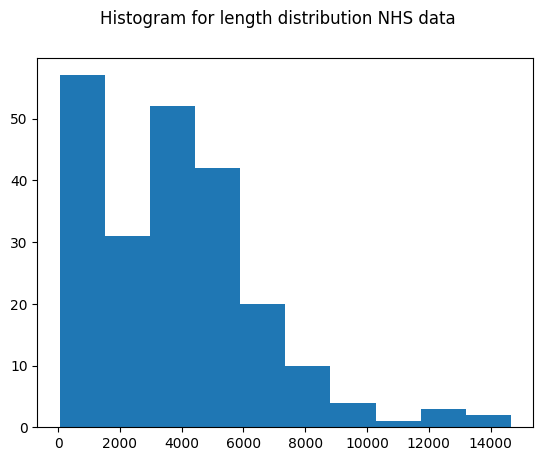

In [11]:
nhs_data['text_scraped'].apply(len).hist(grid=False)
plt.suptitle("Histogram for length distribution NHS data")

In [16]:
nhs_data['text_scraped'].str.len().describe()

count      222.000000
mean      3751.572072
std       2843.689290
min         57.000000
25%       1454.250000
50%       3572.500000
75%       5277.500000
max      14656.000000
Name: text_scraped, dtype: float64

### Mind dataset

Average length of text in Mind dataset is 4965 words. Considering all texts are of the same length, we add these texts in vector store and get 4 nearest neighbours for query question. This puts length of context = 19860 words (4965 x 4).

Text(0.5, 0.98, 'Histogram for length distribution Mind data')

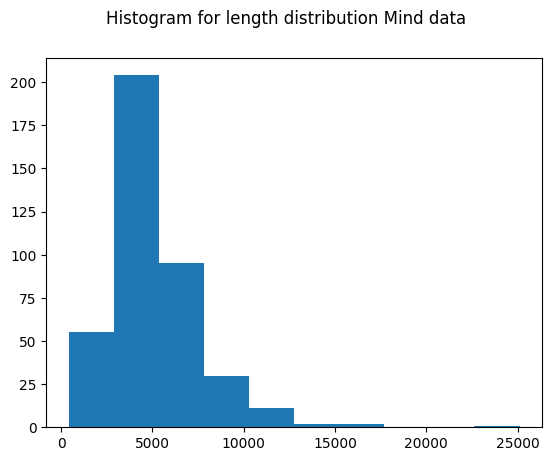

In [12]:
mind_data['text_scraped'].apply(len).hist(grid=False)
plt.suptitle("Histogram for length distribution Mind data")

In [17]:
mind_data['text_scraped'].str.len().describe()

count      400.000000
mean      4965.332500
std       2633.483565
min        415.000000
25%       3190.250000
50%       4307.000000
75%       6111.000000
max      25110.000000
Name: text_scraped, dtype: float64